In [ ]:
!pip install scikeras
import scikeras
import sklearn

print(scikeras.__version__) # required 0.13.0
print(sklearn.__version__) # required 1.2.2

0.13.0
1.5.2


In [ ]:
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
%%capture
%pip install optuna

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf

import optuna

import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score, precision_recall_curve, average_precision_score,  fbeta_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import learning_curve


seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


In [ ]:
column_names = [
    'Status of existing checking account', 'Duration in month', 'Credit history',
    'Purpose', 'Credit amount', 'Savings account/bonds', 'Present employment since',
    'Installment rate in percentage of disposable income', 'Personal status and sex',
    'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
    'Other installment plans', 'Housing', 'Number of existing credits at this bank',
    'Job', 'Number of people being liable to provide maintenance for', 'Telephone',
    'foreign worker', 'Good/Bad'
]

df = pd.read_csv('german.data', delim_whitespace=True, header=None, names=column_names)
df


,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Good/Bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_columns = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds',
                        'Present employment since', 'Personal status and sex', 'Other debtors / guarantors',
                        'Property', 'Other installment plans', 'Housing', 'Job', 'Telephone', 'foreign worker']

encoder = OneHotEncoder(drop='first', sparse=False).set_output(transform="pandas")

encoder.fit(X_train[categorical_columns])

X_train_encoded = encoder.transform(X_train[categorical_columns])
X_val_encoded = encoder.transform(X_val[categorical_columns])

In [ ]:
numerical_columns = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income', 'Present residence since',
                     'Age in years', 'Number of existing credits at this bank', 'Number of people being liable to provide maintenance for']


scaler = StandardScaler()

X_train_scaled = X_train_encoded.copy()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

X_val_scaled = X_val_encoded.copy()
X_val_scaled[numerical_columns] = scaler.transform(X_val[numerical_columns])

In [ ]:
y_train = y_train.values - 1 if isinstance(y_train, pd.Series) else y_train - 1
y_val = y_val.values - 1 if isinstance(y_val, pd.Series) else y_val - 1

# Hyperparameter tuning: yes; class weights: yes

In [ ]:
#BEST MODEL
np.random.seed(42)
def f2_class_2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1, average='binary')

f2_scorer_class_2 = make_scorer(f2_class_2)
class_weights = {
    0: 1,
    1: 5
}

def create_model(optimizer='adam', learn_rate=0.001,
                 dense_units_1=32, dense_units_2=32, dense_units_3=16,
                 dropout_rate=0.5):
    model = Sequential()

    model.add(Dense(dense_units_1, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units_2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units_3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=learn_rate) if optimizer == 'adam' else RMSprop(learning_rate=learn_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[Precision(), Recall()])

    return model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = KerasClassifier(build_fn=create_model,callbacks=[early_stop],  epochs = 100, verbose = 0, class_weight=class_weights)

param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learn_rate': [0.001, 0.01],
    'model__dense_units_1': [32],
    'model__dense_units_2': [16],
    'model__dense_units_3': [8],
    'model__dropout_rate': [0.3]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=f2_scorer_class_2, cv=5)

grid_result = grid.fit(X_train_scaled, y_train, **{'shuffle': False})

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

best_model = grid_result.best_estimator_

best_keras_model = best_model.model_
best_keras_model.summary()

y_val_pred_proba = best_model.predict(X_val_scaled)

y_val_pred = (y_val_pred_proba > 0.5).astype(int)

Best: 0.6810465159521879 using {'model__dense_units_1': 32, 'model__dense_units_2': 16, 'model__dense_units_3': 8, 'model__dropout_rate': 0.3, 'model__learn_rate': 0.001, 'model__optimizer': 'adam'}


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)                    │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_135              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_136              │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_136 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_137              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_137 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173 (28.02 KB)

 Trainable params: 2,353 (9.19 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 4,708 (18.39 KB)

Training F2 Score: 0.85
Validation F2 Score: 0.65


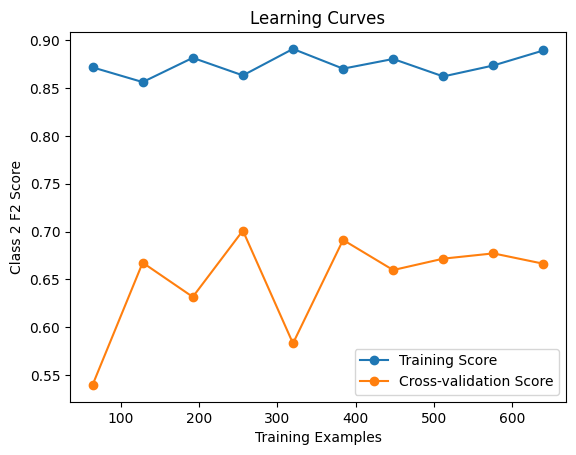

Validation Accuracy: 0.63
Confusion Matrix:
 [[44 15]
 [59 82]]
F2 Score:
Class Good (1): 0.62
Class Bad (2): 0.65
Macro avg: 0.63
Weighted avg: 0.63
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.85      0.58      0.69       141
     Bad (2)       0.43      0.75      0.54        59

    accuracy                           0.63       200
   macro avg       0.64      0.66      0.62       200
weighted avg       0.72      0.63      0.65       200

Balanced Accuracy: 0.66
AUC-ROC: 0.66


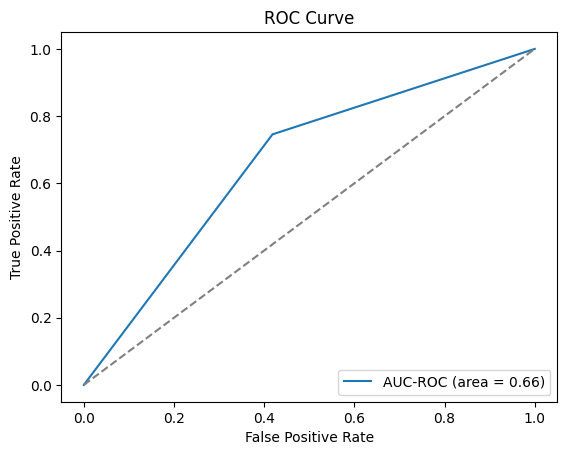

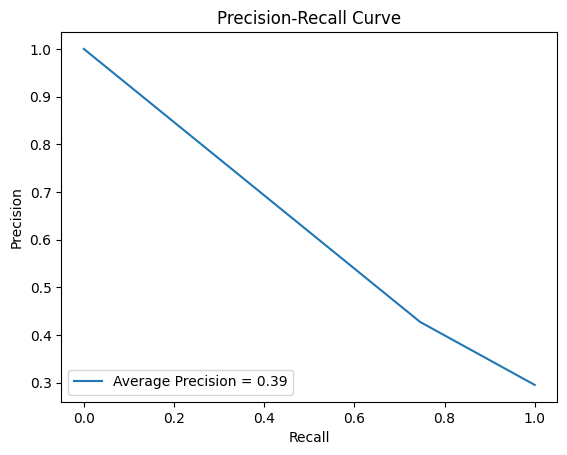

In [ ]:
y_train_pred = grid.best_estimator_.predict(X_train_scaled)
train_f2_score = fbeta_score(y_train, y_train_pred, beta=2, average='binary')

val_f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='binary')

print(f'Training F2 Score: {train_f2_score:.2f}')
print(f'Validation F2 Score: {val_f2_score:.2f}')

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5,
    scoring=f2_scorer_class_2,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Class 2 F2 Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()


accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred, labels = [1,0])
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# hyperparameter tuning: no; classes weights: yes


In [ ]:

model = Sequential()

model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weight = {0: 1., 1: 5.}


history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    class_weight=class_weight

)

model.summary()

y_val_pred_proba = model.predict(X_val_scaled)

y_val_pred = (y_val_pred_proba > 0.5).astype(int)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.6778 - precision_237: 0.2860 - recall_237: 0.5770 - val_loss: 0.7224 - val_precision_237: 0.2533 - val_recall_237: 0.6441
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4703 - precision_237: 0.2889 - recall_237: 0.6188 - val_loss: 0.7487 - val_precision_237: 0.2809 - val_recall_237: 0.8475
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3793 - precision_237: 0.2867 - recall_237: 0.6238 - val_loss: 0.7864 - val_precision_237: 0.2902 - val_recall_237: 0.9492
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6715 - precision_237: 0.2632 - recall_237: 0.6085 - val_loss: 0.8185 - val_precision_237: 0.2879 - val_recall_237: 0.9661
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3293 - precision_237: 0.2845 - recall_237: 0.6704 - val_loss: 0.8460 - val_precision_237: 0.2879 - val_recall_237: 0.9661
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3264 - precision_237: 0

Model: "sequential_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_951 (Dense)                    │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_714              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_714 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_952 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_715              │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_715 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_953 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_716              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_716 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_954 (Dense)                    │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_717              │ (None, 4)                   │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_717 (Dropout)                │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_955 (Dense)                    │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,301 (28.52 KB)

 Trainable params: 2,393 (9.35 KB)

 Non-trainable params: 120 (480.00 B)

 Optimizer params: 4,788 (18.71 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Validation Accuracy: 0.34
Confusion Matrix:
 [[ 29 112]
 [ 21  38]]
F2 Score:
Class Good (1): 0.24
Class Bad (2): 0.49
Macro avg: 0.36
Weighted avg: 0.31
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.58      0.21      0.30       141
     Bad (2)       0.25      0.64      0.36        59

    accuracy                           0.34       200
   macro avg       0.42      0.42      0.33       200
weighted avg       0.48      0.34      0.32       200

Balanced Accuracy: 0.42
AUC-ROC: 0.35


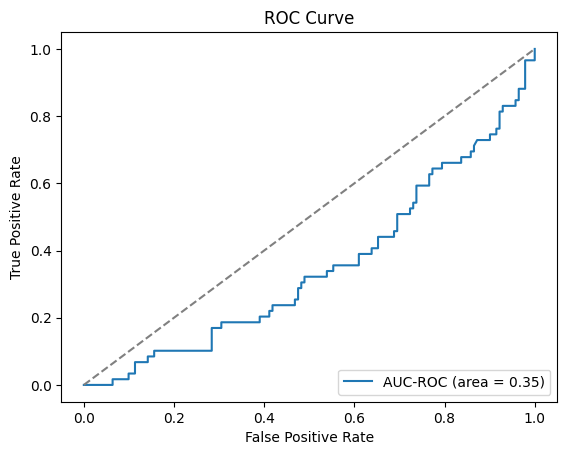

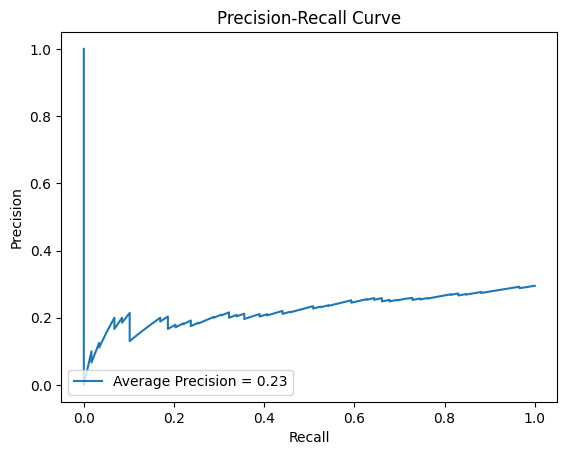

In [ ]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# hyperparameter tuning: no; class weights: yes (custom loss function)

In [ ]:
model = Sequential()

model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

cost_matrix = tf.constant([[0, 1], [5, 0]], dtype=tf.float32)

def weighted_binary_crossentropy(cost_matrix):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=2)

        y_pred_expanded = K.expand_dims(y_pred, axis=-1)

        weighted_losses_pos = y_true_one_hot * cost_matrix * K.log(y_pred_expanded)
        weighted_losses_neg = (1 - y_true_one_hot) * cost_matrix * K.log(1 - y_pred_expanded)

        return K.mean(K.sum(weighted_losses_pos + weighted_losses_neg, axis=-1))

    return loss
model.compile(optimizer='adam',
              loss=weighted_binary_crossentropy(cost_matrix),
              metrics=[Precision(), Recall()])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,

)

model.summary()

y_val_pred_proba = model.predict(X_val_scaled)

y_val_pred = (y_val_pred_proba > 0.5).astype(int)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: -3.1818 - precision_1: 0.3026 - recall_1: 0.3916 - val_loss: -2.2407 - val_precision_1: 0.3667 - val_recall_1: 0.1864
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -3.6672 - precision_1: 0.2956 - recall_1: 0.4598 - val_loss: -2.5880 - val_precision_1: 0.5000 - val_recall_1: 0.0508
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -4.1282 - precision_1: 0.3629 - recall_1: 0.4720 - val_loss: -3.1677 - val_precision_1: 0.6667 - val_recall_1: 0.0678
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -5.0284 - precision_1: 0.3627 - recall_1: 0.4418 - val_loss: -4.0903 - val_precision_1: 0.6000 - val_recall_1: 0.1017
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -6.1834 - precision_1: 0.4003 - recall_1: 0.4734 - val_loss: -5.3848 - val_precision_1: 0.5263 - val_recall_1: 0.1695
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -6.8809 - precision_1: 0.4191 - recall_1: 0.4349 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,181 (71.02 KB)

 Trainable params: 5,985 (23.38 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 11,972 (46.77 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Validation Accuracy: 0.78
Confusion Matrix:
 [[127  14]
 [ 31  28]]
F2 Score:
Class Good (1): 0.88
Class Bad (2): 0.5
Macro avg: 0.69
Weighted avg: 0.77
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.80      0.90      0.85       141
     Bad (2)       0.67      0.47      0.55        59

    accuracy                           0.78       200
   macro avg       0.74      0.69      0.70       200
weighted avg       0.76      0.78      0.76       200

Balanced Accuracy: 0.69
AUC-ROC: 0.72


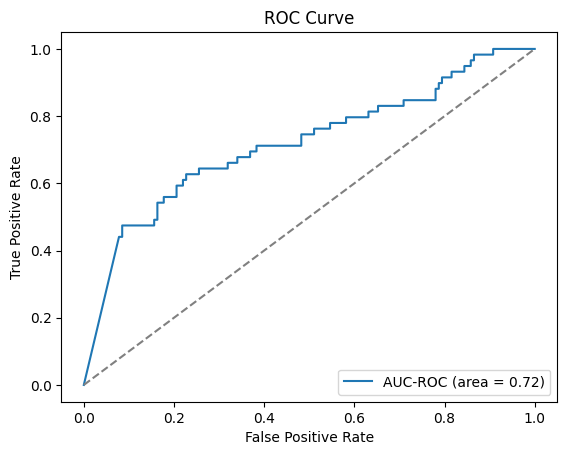

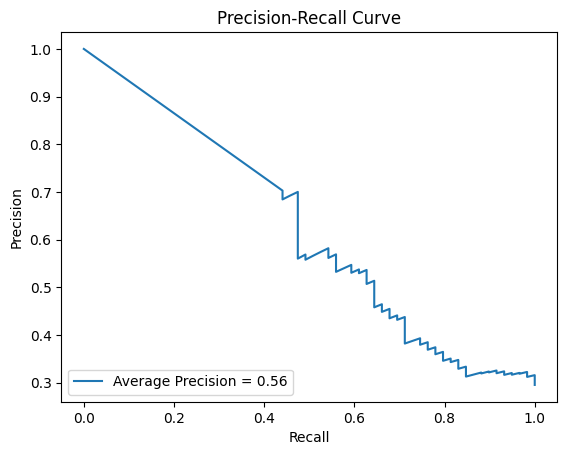

In [ ]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# hyperparameter tuning: Optuna; classes weights: yes


In [ ]:
def cost_based_metric(y_true, y_pred):
    cost_matrix = {
        (1, 1): 0,
        (1, 2): 1,
        (2, 1): 5,
        (2, 2): 0
    }

    cm = confusion_matrix(y_true, y_pred, labels=[1, 2])

    cost = (cm[0, 0] * cost_matrix[(1, 1)] +
            cm[0, 1] * cost_matrix[(1, 2)] +
            cm[1, 0] * cost_matrix[(2, 1)] +
            cm[1, 1] * cost_matrix[(2, 2)])

    return cost

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=1000,
        random_state=42
    )

    mlp.fit(X_train_scaled, y_train)

    y_pred = mlp.predict(X_val_scaled)

    cost = cost_based_metric(y_val, y_pred)

    return -cost

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print(f"  Cost: {-trial.value}")
print("  Best hyperparameters: ", trial.params)

best_mlp = MLPClassifier(
    hidden_layer_sizes=trial.params['hidden_layer_sizes'],
    activation=trial.params['activation'],
    solver=trial.params['solver'],
    alpha=trial.params['alpha'],
    learning_rate=trial.params['learning_rate'],
    max_iter=1000,
    random_state=42
)

best_mlp.fit(X_train_scaled, y_train)

y_val_pred = best_mlp.predict(X_val_scaled)
y_pred_proba = best_mlp.predict_proba(X_val_scaled)[:, 1]

Best trial:
  Cost: -0.0
  Best hyperparameters:  {'hidden_layer_sizes': (100, 100), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006093405168211812, 'learning_rate': 'adaptive'}


Validation Accuracy: 0.76
Confusion Matrix:
 [[123  18]
 [ 31  28]]
F2 Score:
Class Good (1): 0.86
Class Bad (2): 0.5
Macro avg: 0.68
Weighted avg: 0.75
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.80      0.87      0.83       141
     Bad (2)       0.61      0.47      0.53        59

    accuracy                           0.76       200
   macro avg       0.70      0.67      0.68       200
weighted avg       0.74      0.76      0.75       200

Balanced Accuracy: 0.67
AUC-ROC: 0.72


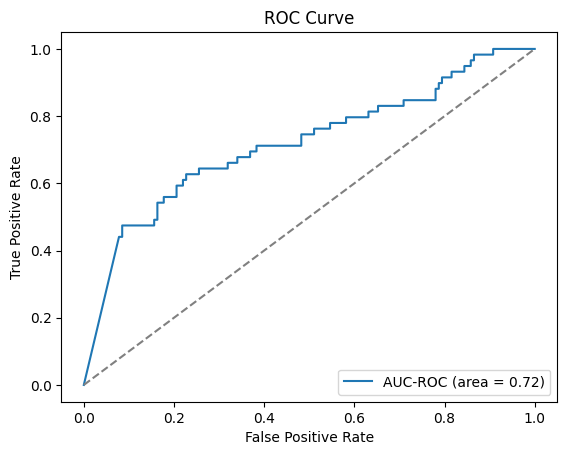

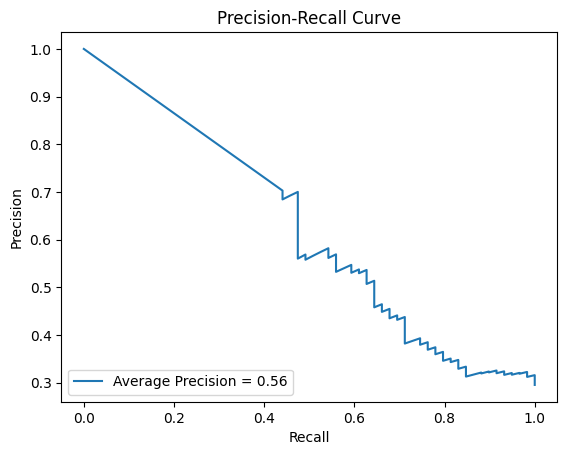

In [ ]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Hyperparamter tuning: yes; class weights: yes (custom loss function)

In [ ]:
cost_matrix = tf.constant([[0, 1], [5, 0]], dtype=tf.float32)
def f2_class_2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=2, average='binary')

f2_scorer_class_2 = make_scorer(f2_class_2)

def weighted_binary_crossentropy(cost_matrix):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=2)

        y_pred_expanded = K.expand_dims(y_pred, axis=-1)

        weighted_losses_pos = y_true_one_hot * cost_matrix * K.log(y_pred_expanded)
        weighted_losses_neg = (1 - y_true_one_hot) * cost_matrix * K.log(1 - y_pred_expanded)

        return K.mean(K.sum(weighted_losses_pos + weighted_losses_neg, axis=-1))

    return loss

def create_model(optimizer='adam', learn_rate=0.001,
                 dense_units_1=32, dense_units_2=32, dense_units_3=16,
                 dropout_rate=0.5):
    model = Sequential()

    model.add(Dense(dense_units_1, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units_2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units_3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=learn_rate) if optimizer == 'adam' else RMSprop(learning_rate=learn_rate)

    model.compile(optimizer=opt, loss=weighted_binary_crossentropy(cost_matrix), metrics=[Precision(), Recall()])

    return model


model = KerasClassifier(build_fn=create_model, verbose=0, epochs = 50)

param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learn_rate': [0.001],
    'model__dense_units_1': [32],
    'model__dense_units_2': [16],
    'model__dense_units_3': [8],
    'model__dropout_rate': [0.3]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=f2_scorer_class_2, cv=5)

grid_result = grid.fit(X_train_scaled, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

best_model = grid_result.best_estimator_

best_keras_model = best_model.model_
best_keras_model.summary()

y_val_pred_proba = best_model.predict(X_val_scaled)

y_val_pred = (y_val_pred_proba > 0.5).astype(int)

Best: nan using {'model__dense_units_1': 32, 'model__dense_units_2': 16, 'model__dense_units_3': 8, 'model__dropout_rate': 0.3, 'model__learn_rate': 0.001, 'model__optimizer': 'adam'}


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_256 (Dense)                    │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_192              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_192 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_257 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_193              │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_193 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_258 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_194              │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_194 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173 (28.02 KB)

 Trainable params: 2,353 (9.19 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 4,708 (18.39 KB)

Validation Accuracy: 0.78
Confusion Matrix:
 [[ 24  35]
 [ 10 131]]
F2 Score:
Class Good (1): 0.9
Class Bad (2): 0.44
Macro avg: 0.67
Weighted avg: 0.76
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.79      0.93      0.85       141
     Bad (2)       0.71      0.41      0.52        59

    accuracy                           0.78       200
   macro avg       0.75      0.67      0.68       200
weighted avg       0.76      0.78      0.75       200

Balanced Accuracy: 0.67
AUC-ROC: 0.67


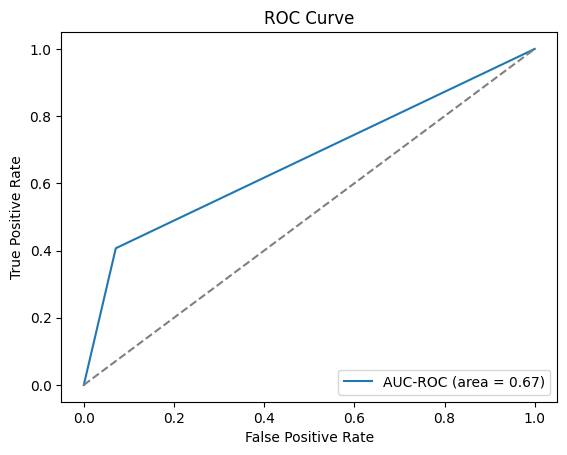

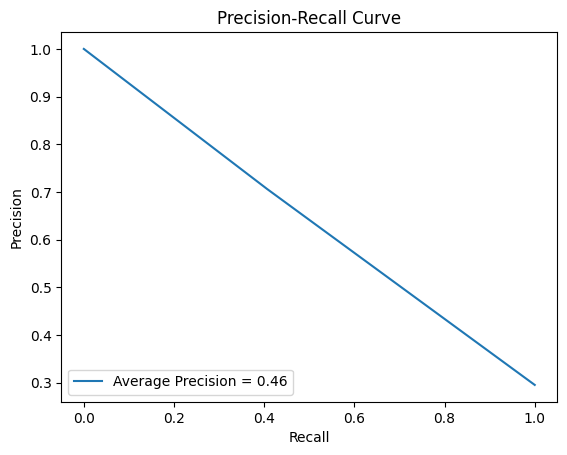

In [ ]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred, labels=[ 1,0])
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()